## Data Ingestion from the CSV file of the air quality dataset to InfluxDB on AWS EC2

In [1]:
import pandas as pd
import datetime as dt
from numpy import float64
import matplotlib.pyplot as plt
import seaborn as sns

# Import the new influxdb API client
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

# Read the csv into a dataframe
df = pd.read_csv("data/PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [2]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


<Figure size 720x432 with 0 Axes>

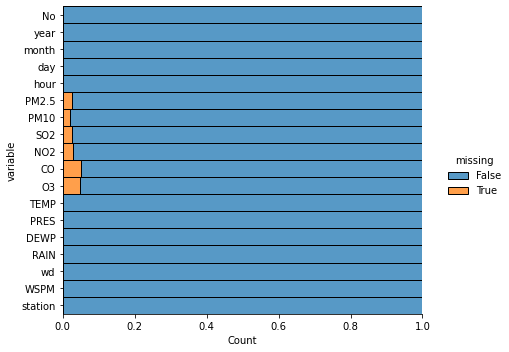

In [3]:
# Identify missing values
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
    )
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)


Text(0.5, 1.0, 'Quantifying missing data')

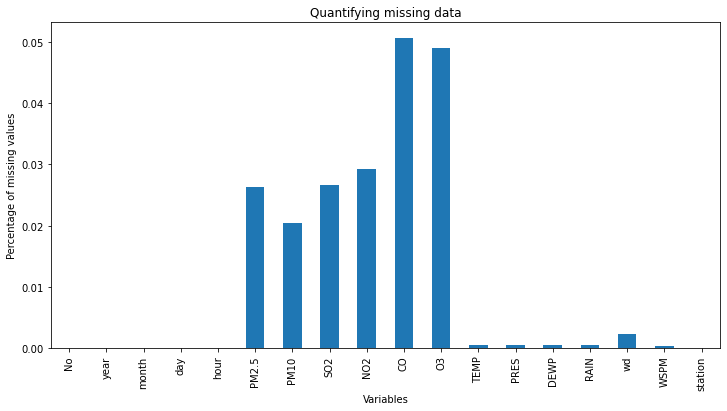

In [4]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [5]:
df.dropna(axis=0, how='any', inplace=True)

Text(0.5, 1.0, 'Quantifying missing data')

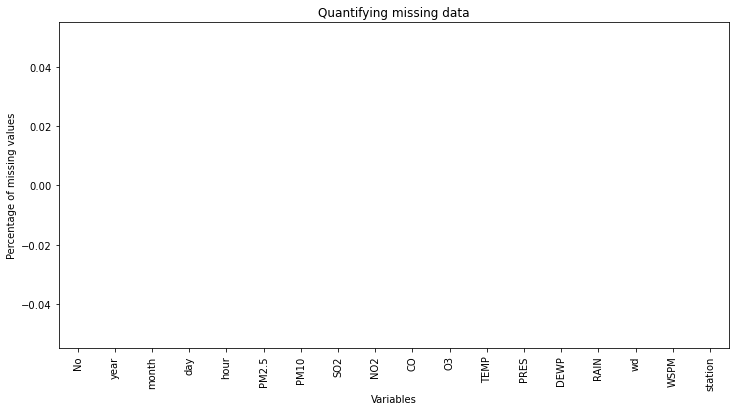

In [6]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [7]:
# As there is no timestamp on the dataset, only 4 separate column
# I am creating a timestamp out of the four columns
# needed for influx 2020-01-01T00:00:00.00Z
# lambda s : dt.datetime(*s) takes every row and convert them -> *s
# strftime to reformat the string into influxdb timestamp format
df['TimeStamp'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda s: dt.datetime(*s).strftime('%Y-%m-%dT%H:%M:%SZ'), axis=1)

In [8]:
# setting the timestamp as the index of the dataframe
df.set_index('TimeStamp', inplace=True)

In [9]:
# dropping the year, month, day, hour, No from the dataframe
converted_ts = df.drop(['year', 'month', 'day', 'hour', 'No'], axis=1)

In [10]:
print(converted_ts)

                      PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
TimeStamp                                                                  
2013-03-01T00:00:00Z    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
2013-03-01T01:00:00Z    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2013-03-01T02:00:00Z    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
2013-03-01T03:00:00Z    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
2013-03-01T04:00:00Z    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   
...                     ...   ...   ...   ...    ...   ...   ...     ...   
2017-02-28T19:00:00Z   12.0  29.0   5.0  35.0  400.0  95.0  12.5  1013.5   
2017-02-28T20:00:00Z   13.0  37.0   7.0  45.0  500.0  81.0  11.6  1013.6   
2017-02-28T21:00:00Z   16.0  37.0  10.0  66.0  700.0  58.0  10.8  1014.2   
2017-02-28T22:00:00Z   21.0  44.0  12.0  87.0  700.0  35.0  10.5  1014.4   
2017-02-28T23:00:00Z   19.0  31.0  10.0  79.0  600.0  42.0   8.6  1014.1   

           

In [11]:
# Changing the column types to float
ex_df = converted_ts.astype({"PM2.5": float64,
                             "PM10": float64,
                             "SO2": float64,
                             "NO2": float64,
                             "CO": float64,
                             "O3": float64,
                             "TEMP": float64,
                             "PRES": float64,
                             "DEWP": float64,
                             "RAIN": float64,
                             "WSPM": float64})

In [12]:
# Defining tag fields
datatags = ['station', 'wd']

In [13]:
#Setting up Database (Connection string)
client = influxdb_client.InfluxDBClient(
    url='ec2-3-120-10-156.eu-central-1.compute.amazonaws.com:8086',
    token='kp_gJV8Y7aOZB0odriHj1o_qWurQmxzBXpTU_kYY4JnQ88e9X1TI3ifFVA1pUyGZshZfTpeaTlTWgYAUESTMvw==',
    org='my-org'
)

In [14]:
# Writing the data with two tags
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='full-tags', data_frame_tag_columns=['station', 'wd'])
print(message)

ConnectTimeoutError: (<urllib3.connection.HTTPConnection object at 0x000001890DDA7DF0>, 'Connection to ec2-35-157-40-78.eu-central-1.compute.amazonaws.com timed out. (connect timeout=10.0)')

In [60]:
# The asynchronous buffering API to Write time-series data into InfluxDB.
# This API always buffers points/lines to create batches under the hood to optimize data 
# transfer to InfluxDB server, flush is used to send the buffered data to InfluxDB immediately.
# I use flush() after each write as I was getting a "time out error message"
write_api.flush()

In [61]:
# Writing the data only with one tag
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='location-tag-only', data_frame_tag_columns=['station'])
print('Errors detected writing data to InfluxDB: ', message)

None


In [62]:
write_api.flush()